In [ ]:
import tensorflow as tf
import os
import lxml.etree
import tqdm.notebook
import cv2
import numpy as np
import shutil
from google.colab import drive
drive.mount('/gdrive')
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
    BatchNormalization,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

Mounted at /gdrive


In [ ]:
from tqdm.notebook import tqdm

# <h2> Data Preparation for Japan Dataset </h2>

<h3> Splitting files(80:20) and creating text file train and validation </h3>

In [ ]:
filenames = os.listdir('/gdrive/MyDrive/Casestudy2/train/Japan/images')
split = int(len(filenames)*0.8)
with open('/gdrive/MyDrive/Casestudy2/train/Japan/train.txt','w') as file:
  for line in tqdm(filenames[:split]):
    file.write('%s\n' %line.split('.')[0])
file.close()

In [ ]:

with open('/gdrive/MyDrive/Casestudy2/train/Japan/val.txt','w') as file:
  for line in tqdm(filenames[split:]):
    file.write('%s\n' %line.split('.')[0])
file.close()

<h2> Data Preparation for India Dataset </h2>

In [ ]:
filenames = os.listdir('/gdrive/MyDrive/Casestudy2/train/India/images')
split = int(len(filenames)*0.8)
with open('/gdrive/MyDrive/Casestudy2/train/India/train.txt','w') as file:
  for line in tqdm(filenames[:split]):
    file.write('%s\n' %line.split('.')[0])
file.close()


# data for validation
with open('/gdrive/MyDrive/Casestudy2/train/India/val.txt','w') as file:
  for line in tqdm(filenames[split:]):
    file.write('%s\n' %line.split('.')[0])
file.close()

# <h2> Data Preparation for Combined Dataset </h2>

<h3> Splitting files(70:30) and creating text file train and validation </h3>

In [ ]:
filenames = os.listdir('/content/Combined_Data/images')
split = int(len(filenames)*0.7)
with open('/gdrive/MyDrive/Casestudy2/train/Combined_Dataset/train.txt','w') as file:
  for line in tqdm(filenames[:split]):
    file.write('%s\n' %line.split('.')[0])
file.close()

In [ ]:

with open('/gdrive/MyDrive/Casestudy2/train/Combined_Dataset/val.txt','w') as file:
  for line in tqdm(filenames[split:]):
    file.write('%s\n' %line.split('.')[0])
file.close()

In [ ]:
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import imgaug as ia

In [ ]:
import shutil
shutil.unpack_archive('train.tar.gz','/content/')

In [ ]:
PATH = '/content/train/Japan/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'train'
OUTPUT_FILE = '/gdrive/MyDrive/Casestudy2/train/Japan/train_japan_augmented.tfrecord'

In [ ]:
def parse_xml(xml):
  ''' parsing xml file inorder to create TFRecords '''
  if not len(xml):
    return {xml.tag : xml.text}
  result = {}
  for child in xml:
    child_result = parse_xml(child)
    if child.tag != 'object':
      result[child.tag] = child_result[child.tag]
    else:
      if child.tag not in result:
        result[child.tag] = []
      result[child.tag].append(child_result[child.tag])
  return {xml.tag : result}


In [ ]:
def create_tfrecord(path,xml,class_map,data,augmentation):
  ''' creating tf records '''
  images = os.path.join(path,'images',xml['filename'])
  img_raw = open(images,'rb').read()
  img = cv2.imread(images)
  width = int(xml['size']['width'])
  height = int(xml['size']['height'])
  if data == 'train' and augmentation:
    # for train dataset and if augmentation
    augseq = iaa.Sequential([
      
      iaa.Fliplr(0.5), # horizontally flip 50% of the images
      
      
      ], random_order=True)
    Xmin = []
    Xmax = []
    Ymin = []
    Ymax = []
    classes = []
    classes_text = []
    bbs = []
    if 'object' in xml:
      for obj in xml['object']:
        if obj['name'] not in class_map:
          continue
        xmin = int(obj['bndbox']['xmin'])
        ymin = int(obj['bndbox']['ymin'])
        xmax = int(obj['bndbox']['xmax'])
        ymax = int(obj['bndbox']['ymax'])
        classes.append(class_map[obj['name']])
        classes_text.append(obj['name'].encode('utf8'))
        bbs.append(BoundingBox(xmin,ymin,xmax,ymax,label=obj['name'].encode('utf8')))
      bbs = BoundingBoxesOnImage(bbs, shape=img.shape)
    if bbs:
      aug_images,aug_boxes = augseq(image=img, bounding_boxes=bbs)
      aug_boxes = aug_boxes.remove_out_of_image().clip_out_of_image()
      for bb in aug_boxes.bounding_boxes:
        Xmin.append(bb.x1/width)
        Ymin.append(bb.y1/height)
        Xmax.append(bb.x2/width)
        Ymax.append(bb.y2/height)
    else:
      aug_images = augseq(image=img)  

 
    Temp_PATH = '/content/augmented.jpg'
    # saving image and reading it in byte form
    cv2.imwrite(Temp_PATH,aug_images)
    
  
    img_raw = open(Temp_PATH,'rb').read()

    
  
    example = tf.train.Example(features = tf.train.Features(feature={
        'image/height' : tf.train.Feature(int64_list = tf.train.Int64List(value=[height])),
        'image/width' : tf.train.Feature(int64_list = tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin' : tf.train.Feature(float_list = tf.train.FloatList(value=Xmin)),
        'image/object/bbox/ymin' : tf.train.Feature(float_list = tf.train.FloatList(value=Ymin)),
        'image/object/bbox/xmax' : tf.train.Feature(float_list = tf.train.FloatList(value=Xmax)),
        'image/object/bbox/ymax' : tf.train.Feature(float_list = tf.train.FloatList(value=Ymax)),
        'image/filename' : tf.train.Feature(bytes_list = tf.train.BytesList(value = [xml['filename'].encode('utf8')])),
        'image/encoded' : tf.train.Feature(bytes_list = tf.train.BytesList(value=[img_raw])),
        'image/object/class/label' : tf.train.Feature(int64_list = tf.train.Int64List(value=classes)),
        'image/object/class/text' : tf.train.Feature(bytes_list = tf.train.BytesList(value=classes_text)),
    }))

  else:
    # for validation dataset or dataset without augmentation
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    if 'object' in xml:
      for obj in xml['object']:
        if obj['name'] not in class_map:
          continue
        xmin.append(float(obj['bndbox']['xmin'])/width)
        ymin.append(float(obj['bndbox']['ymin'])/height)
        xmax.append(float(obj['bndbox']['xmax'])/width)
        ymax.append(float(obj['bndbox']['ymax'])/height)
        classes.append(class_map[obj['name']])
        classes_text.append(obj['name'].encode('utf8'))
    example = tf.train.Example(features = tf.train.Features(feature={
        'image/height' : tf.train.Feature(int64_list = tf.train.Int64List(value=[height])),
        'image/width' : tf.train.Feature(int64_list = tf.train.Int64List(value=[width])),
        'image/object/bbox/xmin' : tf.train.Feature(float_list = tf.train.FloatList(value=xmin)),
        'image/object/bbox/ymin' : tf.train.Feature(float_list = tf.train.FloatList(value=ymin)),
        'image/object/bbox/xmax' : tf.train.Feature(float_list = tf.train.FloatList(value=xmax)),
        'image/object/bbox/ymax' : tf.train.Feature(float_list = tf.train.FloatList(value=ymax)),
        'image/filename' : tf.train.Feature(bytes_list = tf.train.BytesList(value = [xml['filename'].encode('utf8')])),
        'image/encoded' : tf.train.Feature(bytes_list = tf.train.BytesList(value=[img_raw])),
        'image/object/class/label' : tf.train.Feature(int64_list = tf.train.Int64List(value=classes)),
        'image/object/class/text' : tf.train.Feature(bytes_list = tf.train.BytesList(value=classes_text)),
    }))


  return example

In [ ]:
def data_prepare(path,classes,output_file,data='train',augmentation=False):
  ''' Preparation of dataset for training yolov3 object detection model '''
  class_map = {name : id for id,name in enumerate(open(classes).read().splitlines())}
  
  writer = tf.io.TFRecordWriter(output_file)
  if data == 'train':
    image_list = open(os.path.join(path, r'train.txt')).read().splitlines()
  else:
    
    image_list = open(os.path.join(path, r'val.txt')).read().splitlines()
  for name in tqdm(image_list):
    annotation_xml = os.path.join(path,'annotations','xmls',name + '.xml')
    annotation_xml = lxml.etree.fromstring(open(annotation_xml).read())
    parsed_xml = parse_xml(annotation_xml)['annotation']
    tf_example = create_tfrecord(path,parsed_xml,class_map,data,augmentation)
    writer.write(tf_example.SerializeToString())
  writer.close()
  print(data + 'record created : ' + output_file)
  return 

In [ ]:
FEATURE_MAP = {
    'image/encoded' : tf.io.FixedLenFeature([],tf.string),
    'image/object/bbox/xmin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax' : tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax' : tf.io.VarLenFeature(tf.float32),
    'image/object/class/text' : tf.io.VarLenFeature(tf.string),
}

In [ ]:

def parse_tfrecord(tfrecord,classes,size):
  '''Function to parse tf records '''
  x = tf.io.parse_single_example(tfrecord,FEATURE_MAP)
  x_train = tf.image.decode_jpeg(x['image/encoded'],channels=3)

  x_train = tf.image.resize(x_train,size=(size,size))
  
  class_text = tf.sparse.to_dense(x['image/object/class/text'],default_value='')
  labels = tf.cast(classes.lookup(class_text),tf.float32)
  y_train = tf.stack([tf.sparse.to_dense(x['image/object/bbox/xmin']),
            tf.sparse.to_dense(x['image/object/bbox/ymin']),
            tf.sparse.to_dense(x['image/object/bbox/xmax']),
            tf.sparse.to_dense(x['image/object/bbox/ymax']),
            labels],axis=1)
  paddings = [[0, 100 - tf.shape(y_train)[0]],[0,0]]
  y_train = tf.pad(y_train,paddings)
  return x_train,y_train


In [ ]:
def load_tfrecord_dataset(filepath,classes,size=416):
  ''' Function to load tfrecords '''
  class_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(classes,tf.string,0,tf.int64,-1,delimiter='\n'),-1)
  files = tf.data.Dataset.list_files(filepath)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x : parse_tfrecord(x,class_table,size))



In [ ]:
def draw_output(image,outputs,class_names):
  ''' Function to draw bounding boxes on image '''
  boxes, objectness, classes, nums = outputs
  boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
  
  wh = np.flip(image.shape[0:2])
  
  for i in range(nums):
    x1y1 = tuple((np.array(boxes[i][0:2])*wh).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][2:4])*wh).astype(np.int32))
    image = cv2.rectangle(image,x1y1,x2y2,(255,0,0),2)
    image = cv2.putText(image,'{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
  return image

In [ ]:
def visualize_dataset(dataset,classes,size,output):
  ''' function to visualize dataset after preparations '''
  class_names = [c.strip() for c in open(classes).readlines()]
  dataset = load_tfrecord_dataset(dataset,classes,size)
  dataset = dataset.shuffle(512)
  for image,labels in dataset.take(1):
    boxes = []
    scores = []
    clas = []
    for x1,y1,x2,y2,label in labels:
      if x1 == 0 and x2 == 0:
        continue
      boxes.append((x1,y1,x2,y2))
      scores.append(1)
      clas.append(label)
    num = [len(boxes)]
    scores = [scores]
    boxes = [boxes]
    clas = [clas]

    for i in range(num[0]):
      print('{} {} {}'.format(class_names[int(clas[0][i])],np.array(scores[0][i]),np.array(boxes[0][i])))
  
    img = cv2.cvtColor(image.numpy(),cv2.COLOR_RGB2BGR)
    img = draw_output(img,(boxes,scores,clas,num),class_names)
    cv2.imwrite(output, img)
    

  return 

<h2> Preparing TF records with augmentation for Japan Dataset </h2>

In [ ]:
PATH = '/content/train/Japan/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'train'
OUTPUT_FILE = '/gdrive/MyDrive/Casestudy2/train/Japan/train_japan_augmented.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=True)


trainrecord created : /gdrive/MyDrive/Casestudy2/train/Japan/train_japan_augmented.tfrecord


In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/Japan/train_japan_augmented.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_japan_train.jpg')

D10 1 [0.11666667 0.43333334 0.5083333  0.48166665]
D10 1 [0.515      0.45666668 0.79833335 0.50166667]


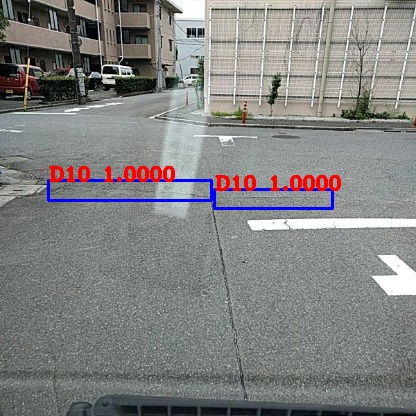

In [ ]:
from IPython.display import Image

Image(filename='/content/output_japan_train.jpg')

In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/Japan/train_japan_augmented.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_japan_train.jpg')

D20 1 [0.02       0.53333336 0.43333334 0.97833335]
D00 1 [0.61833334 0.625      0.72       0.985     ]
D10 1 [0.405      0.575      0.56333333 0.6       ]
D10 1 [0.24666667 0.91833335 0.45666668 0.96666664]


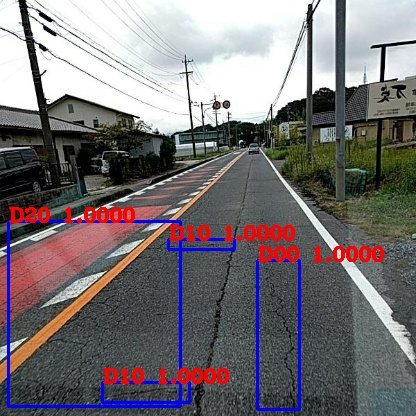

In [ ]:
from IPython.display import Image

Image(filename='/content/output_japan_train.jpg')

In [ ]:
#train tf records
PATH = '/content/train/Japan/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'valid'
OUTPUT_FILE = '/gdrive/MyDrive/Casestudy2/train/Japan/val_japan.tfrecord'
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=False)


validrecord created : /gdrive/MyDrive/Casestudy2/train/Japan/val_japan.tfrecord


In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/Japan/val_japan.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_japan_val.jpg')

D00 1 [0.21833333 0.54833335 0.38       0.68833333]
D00 1 [0.72333336 0.635      0.83166665 0.7183333 ]
D00 1 [0.45833334 0.50666666 0.5083333  0.5683333 ]
D10 1 [0.30666667 0.62333333 0.45       0.6533333 ]


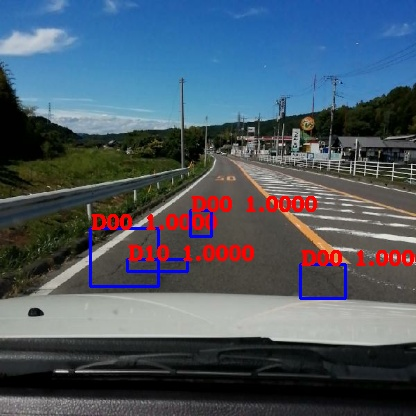

In [ ]:
from IPython.display import Image

Image(filename='/content/output_japan_val.jpg')

In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/Japan/val_japan.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_japan_val.jpg')

D00 1 [0.535     0.795     0.6383333 1.       ]
D10 1 [0.62       0.8433333  0.9266667  0.89166665]
D10 1 [0.5083333  0.72833335 0.59       0.75      ]


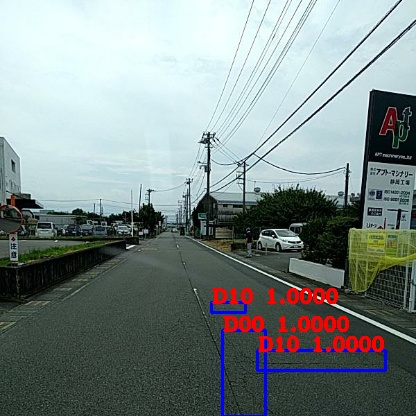

In [ ]:
from IPython.display import Image

Image(filename='/content/output_japan_val.jpg')

<h2> Preparing TF records with augmentation for Indian Dataset </h2>

In [ ]:
PATH = '/content/train/India/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'train'
OUTPUT_FILE = '/gdrive/MyDrive/Casestudy2/train/India/train_india_augmented.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=True)


trainrecord created : /gdrive/MyDrive/Casestudy2/train/India/train_india_augmented.tfrecord


In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/India/train_india_augmented.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_india_train.jpg')

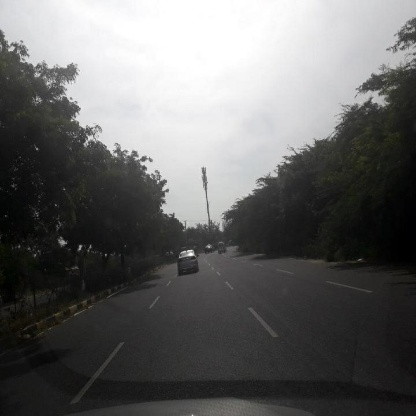

In [ ]:
from IPython.display import Image

Image(filename='/content/output_india_train.jpg')

In [ ]:
visualize_dataset('/gdrive/MyDrive/Casestudy2/train/India/train_india_augmented.tfrecord','/gdrive/MyDrive/Casestudy2/train/road_damage.classes',416,'/content/output_india_train.jpg')

D20 1 [0.00416667 0.73055553 0.28333333 0.8527778 ]


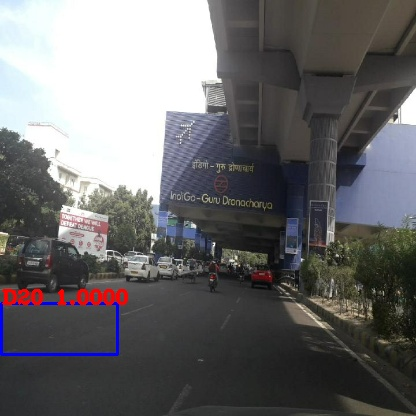

In [ ]:
from IPython.display import Image

Image(filename='/content/output_india_train.jpg')

In [ ]:
PATH = '/content/train/India/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'valid'
OUTPUT_FILE = '/gdrive/MyDrive/Casestudy2/train/India/val_india.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=False)

1



validrecord created : /gdrive/MyDrive/Casestudy2/train/India/val_india.tfrecord


<h2> Preparing TF records without augmentation for Combined India and Japan Dataset </h2>

In [ ]:
PATH = '/content/Combined_Data/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'train'
OUTPUT_FILE = '/content/train_combined_data.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=False)


trainrecord created : /content/train_combined_data.tfrecord


In [ ]:
visualize_dataset('/content/train_combined_data.tfrecord','/content/road_damage.classes',416,'/content/output_train.jpg')

D40 1 [0.4625     0.73194444 0.74583334 0.9652778 ]


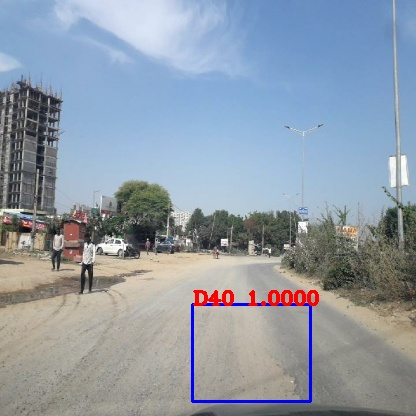

In [ ]:
from IPython.display import Image

Image(filename='/content/output_train.jpg')

In [ ]:
PATH = '/content/Combined_Data/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'val'
OUTPUT_FILE = '/content/val_combined_data.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=False)

1



valrecord created : /content/val_combined_data.tfrecord


In [ ]:
visualize_dataset('/content/val_combined_data.tfrecord','/content/road_damage.classes',416,'/content/output_val.jpg')

D20 1 [0.30166668 0.79333335 0.49       0.99833333]
D20 1 [0.7        0.895      0.7966667  0.99333334]


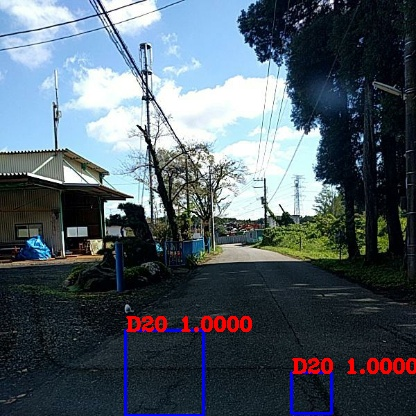

In [ ]:
from IPython.display import Image

Image(filename='/content/output_val.jpg')

In [ ]:
visualize_dataset('/content/val_combined_data.tfrecord','/content/road_damage.classes',416,'/content/output_val.jpg')

D20 1 [0.32       0.65166664 0.505      0.7733333 ]


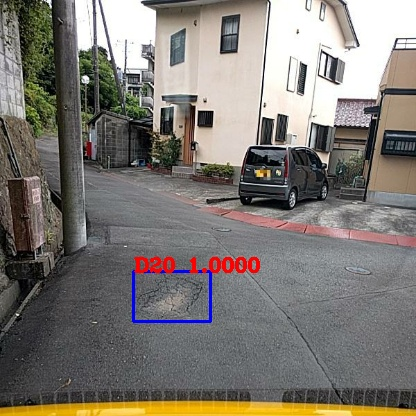

In [ ]:
from IPython.display import Image

Image(filename='/content/output_val.jpg')

In [ ]:
PATH = '/content/Combined_Data/'
CLASS_FILE = '/content/road_damage.classes'
DATA = 'train'
OUTPUT_FILE = '/content/train_augmented_combined_data.tfrecord'

In [ ]:
#train tf records
data_prepare(PATH,CLASS_FILE,OUTPUT_FILE,DATA,augmentation=True)


trainrecord created : /content/train_augmented_combined_data.tfrecord


In [ ]:
visualize_dataset('/content/train_augmented_combined_data.tfrecord','/content/road_damage.classes',416,'/content/output_train.jpg')

D20 1 [0.03472222 0.7222222  0.39722222 0.9305556 ]


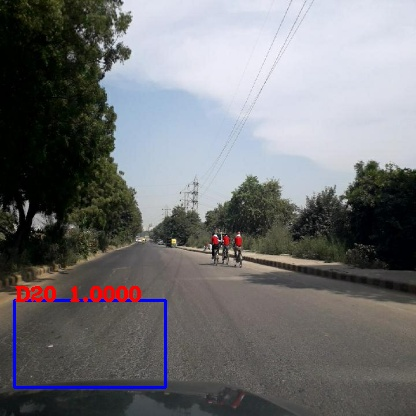

In [ ]:
from IPython.display import Image

Image(filename='/content/output_train.jpg')